# Challenge 02
## InsightExtractor: Leveraging Azure Document Intelligence for Data Retrieval

**Expected Duration:** 60 minutes

This notebook demonstrates how to upload data to Azure Blob Storage, process the data using Azure Document Intelligence, and retrieve the information from these documents in JSON format. The steps include:

1. **Upload Data to Blob Storage**: We will upload documents to Azure Blob Storage for processing.
2. **Process Data with Azure Document Intelligence**: Utilize Azure's Document Intelligence capabilities to analyze and extract information from the uploaded documents.
3. **Retrieve Information in JSON Format**: Extract and retrieve the processed information in JSON format for further use.

## Importance of Document Processing

Automating document processing is crucial for improving efficiency and accuracy in handling large volumes of data. By leveraging Azure's cloud services, organizations can streamline their workflows, reduce manual errors, and gain valuable insights from their documents. This approach not only saves time and resources but also enhances data accessibility and decision-making capabilities.

In [23]:
import os
from dotenv import find_dotenv, load_dotenv
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobSasPermissions
from datetime import datetime, timedelta
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeResult, AnalyzeDocumentRequest
import os

### Step 1- Upload Data to Blob

In this step, we will upload our documents to Azure Blob Storage, which serves as a scalable and secure storage solution for our data. The data used is stored in this challenge's *data* folder.

In [24]:
# Load environment variables from .env file
load_dotenv()

# Retrieve the connection string and data folder from the environment variables
connection_string = os.getenv('STORAGE_CONNECTION_STRING')
data_folder = os.getenv('DATA_FOLDER')
container_name = os.getenv('CONTAINER_NAME')

# Ensure the connection string, data folder, and container name are not None
if connection_string is None:
    raise ValueError("The connection string environment variable is not set.")
if data_folder is None:
    raise ValueError("The data folder environment variable is not set.")
if container_name is None:
    raise ValueError("The container name environment variable is not set.")

# Ensure the data folder exists
if not os.path.isdir(data_folder):
    raise FileNotFoundError(f"The specified data folder does not exist: {data_folder}")

# Create a BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Upload files in the data folder and its subdirectories to the blob container
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        file_path = os.path.join(root, filename)
        if os.path.isfile(file_path):
            # Create a blob path that maintains the directory structure
            blob_path = os.path.relpath(file_path, data_folder).replace("\\", "/")
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_path)
            with open(file_path, "rb") as data:
                blob_client.upload_blob(data, overwrite=True)
            print(f"Uploaded {blob_path} to blob storage.")

Uploaded readme.md to blob storage.
Uploaded loanagreements/la_janesmith.pdf to blob storage.
Uploaded loanform/lp_janesmith.pdf to blob storage.
Uploaded paystubs/paystubjanesmith.pdf to blob storage.


Now go back to your Azure Storage Account on the Azure Portal and you should find a structure such as the following:

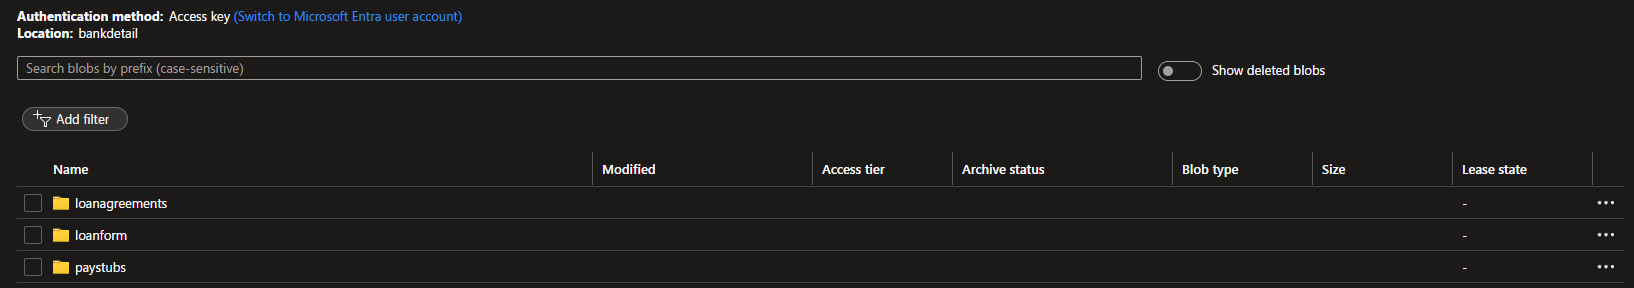

Remember this step, as this will be also the place where:
- In the end of this Challenge we will also upload our .json file, a result of the ADI's OCR
- In Challenge 4 we will be using these folders as a trigger for our function

### Step 2 - Process Data with Azure Document Intelligence

In this step, we will use Azure Document Intelligence to analyze and extract information from the uploaded documents. The code demonstrates how to authenticate with Azure, submit a document for analysis, and retrieve the results, including detected languages, lines, words, and paragraphs.

#### Step 2.1: Generate SAS URL for the specific file to analyse

The first function we are going to use to orchestrate this process is the one that will grant us permissions to access our files. There are two ways of doing this: Generating [SAS URL](https://learn.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and Using Managed Identities. In this hackathon, we will use the first option, as it makes it easier to orchestrate in our code. In this function we have to define:
- What resources the client may access.
- What permissions they have to those resources.
- How long the SAS is valid.

In [25]:
def generate_sas_url(blob_service_client, container_name, blob_name, expiry_hours=1):
    """
    Generate a SAS URL for a blob in Azure Blob Storage.

    :param blob_service_client: BlobServiceClient instance
    :param container_name: Name of the container
    :param blob_name: Name of the blob
    :param expiry_hours: Expiry time in hours for the SAS token
    :return: SAS URL for the blob
    """
    sas_token = generate_blob_sas(
        account_name=blob_service_client.account_name,
        container_name=container_name,
        blob_name=blob_name,
        account_key=blob_service_client.credential.account_key,
        permission=BlobSasPermissions(read=True),
        expiry=datetime.utcnow() + timedelta(hours=expiry_hours)
    )

    sas_url = f"https://{blob_service_client.account_name}.blob.core.windows.net/{container_name}/{blob_name}?{sas_token}"
    return sas_url

#### Step 2.2 - Helper Functions for Document Analysis

The `get_words` function iterates through all words on a given page and uses the _in_span helper function to check if each word falls within the spans of the specified line. If a word is within the line's spans, it is added to the result list. The `_in_span function` checks if a word's span (defined by its offset and length) is entirely contained within any of the given spans. This functionality is useful for accurately extracting and processing text from specific regions of a document.

In [26]:
def get_words(page, line):
    result = []
    for word in page.words:
        if _in_span(word, line.spans):
            result.append(word)
    return result

def _in_span(word, spans):
    for span in spans:
        if word.span.offset >= span.offset and (word.span.offset + word.span.length) <= (span.offset + span.length):
            return True
    return False

#### Step 2.3 - Analyze Document Using Document Intelligence

The `analyze_layout` function takes a SAS (Shared Access Signature) URL of a document and analyzes its layout using the Azure Document Intelligence service. It extracts various elements such as handwritten styles, pages, lines, selection marks, and tables from the document and returns a structured analysis result.

The function constructs an analysis_result dictionary to store the analysis results. It checks if any styles in the document are handwritten and iterates through each page in the document to extract details such as page number, dimensions, lines, and selection marks. For each line, it extracts the text, polygon, and words with their confidence levels. For each selection mark, it extracts the state, polygon, and confidence level.

The function also iterates through each table in the document to extract details such as row count, column count, bounding regions, and cells. For each cell, it extracts the row index, column index, content, and bounding regions.

In the end, it will return a structured analysis_result dictionary that contains the full-detailed analysis of the layout in our document.


In [27]:
def analyze_layout(sas_url):
    document_intelligence_client = DocumentIntelligenceClient(
        endpoint=os.getenv("DOCUMENTINTELLIGENCE_ENDPOINT"), credential=AzureKeyCredential(os.getenv("DOCUMENTINTELLIGENCE_API_KEY"))
    )

    poller = document_intelligence_client.begin_analyze_document(
        "prebuilt-layout", AnalyzeDocumentRequest(url_source=sas_url)
    )

    result: AnalyzeResult = poller.result()

    analysis_result = {
        "handwritten": any([style.is_handwritten for style in result.styles]) if result.styles else False,
        "pages": [],
        "tables": []
    }

    for page in result.pages:
        page_info = {
            "page_number": page.page_number,
            "width": page.width,
            "height": page.height,
            "unit": page.unit,
            "lines": [],
            "selection_marks": []
        }

        if page.lines:
            for line in page.lines:
                line_info = {
                    "text": line.content,
                    "polygon": line.polygon,
                    "words": [{"content": word.content, "confidence": word.confidence} for word in get_words(page, line)]
                }
                page_info["lines"].append(line_info)

        if page.selection_marks:
            for selection_mark in page.selection_marks:
                selection_mark_info = {
                    "state": selection_mark.state,
                    "polygon": selection_mark.polygon,
                    "confidence": selection_mark.confidence
                }
                page_info["selection_marks"].append(selection_mark_info)

        analysis_result["pages"].append(page_info)

    if result.tables:
        for table in result.tables:
            table_info = {
                "row_count": table.row_count,
                "column_count": table.column_count,
                "bounding_regions": [{"page_number": region.page_number, "polygon": region.polygon} for region in table.bounding_regions] if table.bounding_regions else [],
                "cells": [{"row_index": cell.row_index, "column_index": cell.column_index, "content": cell.content, "bounding_regions": [{"page_number": region.page_number, "polygon": region.polygon} for region in cell.bounding_regions] if cell.bounding_regions else []} for cell in table.cells]
            }
            analysis_result["tables"].append(table_info)

    return analysis_result

#### Step 2.4: Save Analysis Results to Blob Storage

Perfect! Now we have a JSON file containing the analysis of our results. What we need to do now is to save it into our Storage Account. We will save this file in the root where the previous version to make sure that we don't add another layer of complexity.

In [28]:
def save_analysis_results(blob_service_client, container_name, blob_name, analysis_results):
    if analysis_results is None:
        print(f"No analysis results for {blob_name}. Skipping save.")
        return

    # Define the name for the results file
    results_blob_name = f"{blob_name}_results.json"

    # Convert the analysis results to JSON
    results_json = json.dumps(analysis_results, indent=2)

    # Upload the results to the blob
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=results_blob_name)
    blob_client.upload_blob(results_json, overwrite=True)

    print(f"Saved analysis results to {results_blob_name}")

### Step 3 -  Main Execution Block

Now all we have to do is run our function that orchestrates all of these components:

In [ ]:
if __name__ == "__main__":
    # Retrieve the connection string and container name from the environment variables
    connection_string = os.getenv('STORAGE_CONNECTION_STRING')
    container_name = os.getenv('CONTAINER_NAME')

    # Ensure the connection string is not None
    if connection_string is None:
        raise ValueError("The connection string environment variable is not set.")

    # Create a BlobServiceClient
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)

    # List all blobs in the container
    blob_list = blob_service_client.get_container_client(container_name).list_blobs()

    # Iterate over each blob
    for blob in blob_list:
        blob_name = blob.name
        print(f"Processing blob: {blob_name}")

        # Ensure the file format is supported
        supported_formats = ['.pdf', '.jpeg', '.jpg', '.png', '.tiff']
        if not any(blob_name.lower().endswith(ext) for ext in supported_formats):
            print(f"Skipping unsupported file format: {blob_name}")
            continue

        # Generate the SAS URL
        sas_url = generate_sas_url(blob_service_client, container_name, blob_name)
        print(f"Generated SAS URL: {sas_url}")

        # Call the analyze_layout function with the SAS URL
        analysis_results = analyze_layout(sas_url)

        # Save the analysis results
        save_analysis_results(blob_service_client, container_name, blob_name, analysis_results)

Inside each folder you should have a structure that has 1 file with .pdf extension as a .json as follows:

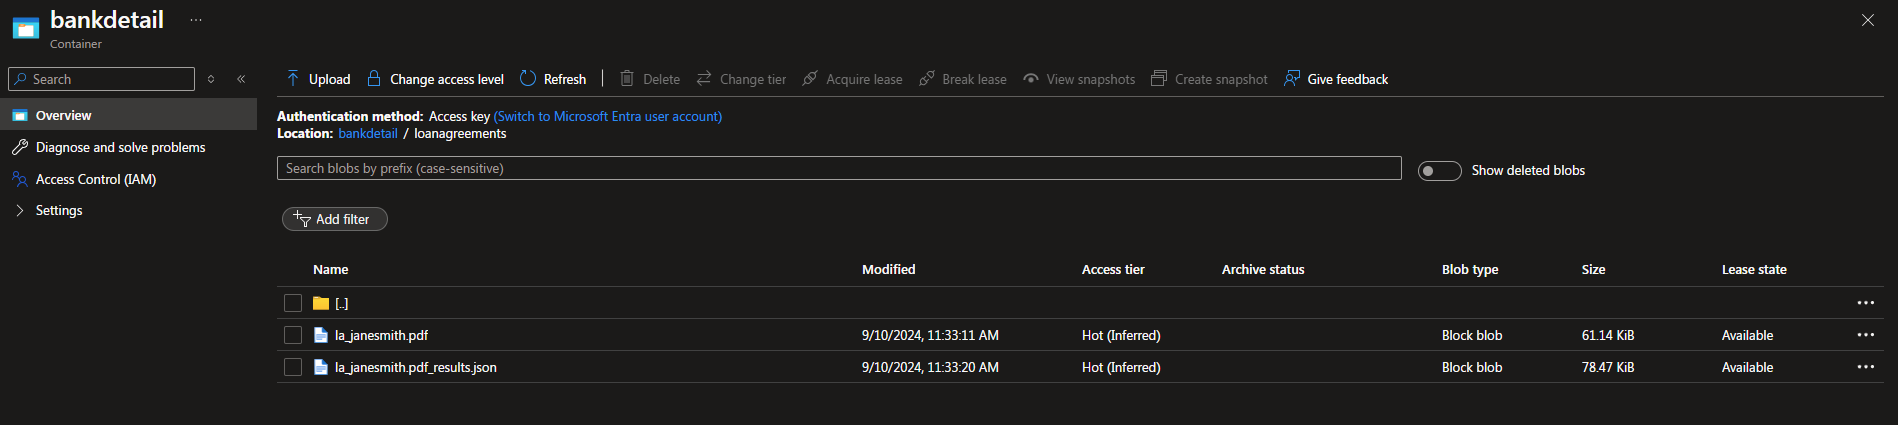